<a href="https://colab.research.google.com/github/Javad1942/Group-2-QBC8/blob/Classification%2FMojtaba-Diana/HBN_and_parquet_feature_extraction_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pyarrow
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
%cd /content/drive/My Drive/bootcamp_project

/content/drive/.shortcut-targets-by-id/1XGS6I_vI23LBKkFLHiNCIiAQUVOr_p2k/bootcamp_project


In [ ]:
!ls

 classification-step1	    final1-data.csv	     khoroji2.csv
 complete.ipynb		    final-HBN.ipynb	     khoroji.csv
'data_dictionary (2).csv'   final_HBN_MOhammad.csv  'model_(1)_(1) (1).ipynb'
 dataset_for_model.csv	    HBN.csv		    'model_(1) (1).ipynb'
 dataset_mohammad.csv	    hbn_dataset.csv	     model.ipynb
 df_HBN_0.csv		    hbn_dataset_final.csv    Parquet.ipynb
 df_HBN_clean.ipynb	    HBN.ipynb		     series_parquet
 feature.ipynb		    HBN_second		     series.parquet.zip


#▶ preprocessed HBN  dataset

In [ ]:
hbn_path = 'hbn_dataset_final.csv'
hbn_data = pd.read_csv(hbn_path)

In [ ]:
hbn_data.head()

,Unnamed: 0,Enrol_Season,Age,Sex,CGAS-Season,CGAS-Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-Season,SDS-Season,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,PCIAT_Variance,PCIAT_Max,PCIAT_HighScores,PCIAT_StdDev,sii,id
0,0.0,0.0,5,0,3.0,51.000000,0.0,16.877316,46.0,50.8,...,0.0,0.0,55.0,3.0,3.671053,5.0,1,1.915999,2.0,00008ff9
1,1.0,2.0,9,0,3.0,65.159266,0.0,14.035590,48.0,46.0,...,0.0,0.0,64.0,0.0,0.000000,0.0,0,0.000000,0.0,000fd460
2,2.0,2.0,10,1,0.0,71.000000,0.0,16.648696,56.5,75.6,...,0.0,0.0,54.0,2.0,1.094737,5.0,1,1.046297,0.0,00105258
3,3.0,3.0,9,0,0.0,71.000000,2.0,18.292347,56.0,81.6,...,2.0,2.0,45.0,0.0,2.694737,5.0,1,1.641565,1.0,00115b9f
4,5.0,1.0,13,1,3.0,50.000000,2.0,22.279952,59.5,112.2,...,2.0,2.0,56.0,0.0,1.168421,3.0,0,1.080935,1.0,001f3379


#▶ parquet dataset

In [ ]:
parquet_data = pd.read_parquet('series_parquet', engine='pyarrow')

In [ ]:
parquet_data.shape

(314569149, 14)

In [ ]:
#‌ ‌Reduce‌ ‌memory‌ ‌usage‌ ‌by‌ ‌converting‌ ‌column‌ ‌data‌ ‌types‌ ‌
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Compute memory usage
    start_mem = df.memory_usage().sum() / 1024**2
    # Iterate through each column
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    # Compute memory usage after reduction
    end_mem = df.memory_usage().sum() / 1024**2
    # Print out the difference between memory usage before and after
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅ پاک کردن دیتاهایی که ستون non-wear_flag شان برابر با 1 ( یعنی ساعت نپوشیده است ) است
</p>

In [ ]:
parquet_data = parquet_data[parquet_data['non-wear_flag'] != 1]

##▶ Feature Extraction

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅ تبدیل داده های ستون time_of_day که در آن زمان به پیکوثانیه محاسبه شده بود به یک ساعت مشخص از روز
</p>

In [ ]:
parquet_data['time_of_day_hours'] = parquet_data['time_of_day'] // (60 * 60 * 1e9)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅ محاسبه شتاب از روی 3 ستون ' X ' , ' Y ' , ' Z '
</p>

In [ ]:
parquet_data['Acceleration_Magnitude'] = np.sqrt(parquet_data['X']**2 + parquet_data['Y']**2 + parquet_data['Z']**2)

In [ ]:
parquet_data = parquet_data.drop(columns=['time_of_day','X','Y','Z'])

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  تعریف بازه‌های تحرک با استفاده از ستون enmo
</p>

In [ ]:
def classify_activity(enmo_value):
    if enmo_value <= 1:
        return 0 #کم
    elif enmo_value <= 5:
        return 1 #متوسط
    else:
        return 2 #زیاد

parquet_data['Activity_Level'] = parquet_data['enmo'].apply(classify_activity)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  محاسبه میانگین و واریانس ستون ' enmo '
</p>

In [ ]:
# گروه‌بندی بر اساس id و محاسبه میانگین و واریانس
enmo_stats = parquet_data.groupby('id')['enmo'].agg(['mean', 'var']).reset_index()
enmo_stats.columns = ['id', 'Mean_Enmo', 'Variance_Enmo']
# ادغام ویژگی‌های جدید با دیتاست اصلی
parquet_data = parquet_data.merge(enmo_stats, on='id', how='left')

<ipython-input-51-c5a323f52ba7>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  enmo_stats = parquet_data.groupby('id')['enmo'].agg(['mean', 'var']).reset_index()


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   تعریف دسته‌بندی  روز با استفاده از ستون time_of_day_hours
</p>

In [ ]:
def time_of_day_category(hour):
    if 6 <= hour < 12:
        return 0  # Morning
    elif 12 <= hour < 18:
        return 1  # Afternoon
    elif 18 <= hour < 24:
        return 2  # Evening
    else:
        return 3  # Night

parquet_data['time_of_day'] = parquet_data['time_of_day_hours'].apply(time_of_day_category)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  محاسبه شاخص ترکیبی سن و وضعیت فیزیکی
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
ترکیب سن و BMI (شاخص توده بدنی) می‌تواند نمایانگر وضعیت کلی سلامت فرد باشد. این ویژگی می‌تواند به مدل کمک کند تا ارتباط بین وضعیت سلامت فرد و الگوی مصرف اینترنت را بررسی کند.
</p>

In [ ]:
hbn_data['Age_Physical_Index'] = hbn_data['Age'] * hbn_data['Physical-BMI']

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  محاسبه شاخص فعالیت آنلاین بر اساس جنسیت و وضعیت فیزیکی
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
این ویژگی می‌تواند ارتباط بین جنسیت و وضعیت فیزیکی (BMI) را مدل کند و ممکن است به شناسایی الگوهای خاص در رفتارهای آنلاین کمک کند. برای مثال، آیا جنسیت و BMI می‌توانند به طور مشترک بر رفتار آنلاین و استفاده از اینترنت تاثیر بگذارند؟
</p>

In [ ]:
hbn_data['Sex_Physical_Health_Index'] = hbn_data['Sex'] * hbn_data['Physical-BMI']

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  محاسبه شاخص ترکیبی سن و جنسیت
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
این ویژگی می‌تواند تاثیر سن و جنسیت را بر مصرف اینترنت نشان دهد. برای مثال، ممکن است مصرف اینترنت در گروه‌های سنی مختلف و جنسیت‌های متفاوت تفاوت‌هایی داشته باشد
</p>

In [ ]:
hbn_data['Age_Sex_Index'] = hbn_data['Age'] * hbn_data['Sex']

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  ترکیب سن، جنسیت و وضعیت فیزیکی
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
این ویژگی می‌تواند تعامل بین سن، جنسیت و وضعیت فیزیکی را مدل کند و ممکن است نشان دهد که چگونه این سه عامل با هم بر رفتار آنلاین افراد تاثیر می‌گذارند.
</p>

In [ ]:
hbn_data['Age_Sex_Physical_Index'] = hbn_data['Age'] * hbn_data['Sex'] * hbn_data['Physical-BMI']

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  ترکیب نمره CGAS با سن و وضعیت فیزیکی
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
نمره CGAS در کنار سن و BMI (وضعیت فیزیکی) می‌تواند نشان‌دهنده تعامل بین وضعیت ذهنی و فیزیکی فرد باشد. مثلاً ممکن است افرادی که وضعیت ذهنی ضعیف‌تری دارند و BMI بالاتری دارند، بیشتر از اینترنت به عنوان یک راه فرار استفاده کنند.
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
** ستون CGAS-Score نشان دهنده معیار کلی میزان عملکرد ذهنی افراد زیر ۱۸ سال است
</p>

In [ ]:
hbn_data['CGAS_Age_Physical_Index'] = hbn_data['CGAS-Score'] * hbn_data['Age'] * hbn_data['Physical-BMI']

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  محاسبه corrolation ستون های جدیدی که ساختیم با ستون target یعنی ' sii ' برای تصمیمی گیری جهت نگه داشتن یا حذف ستون های جدید
</p>

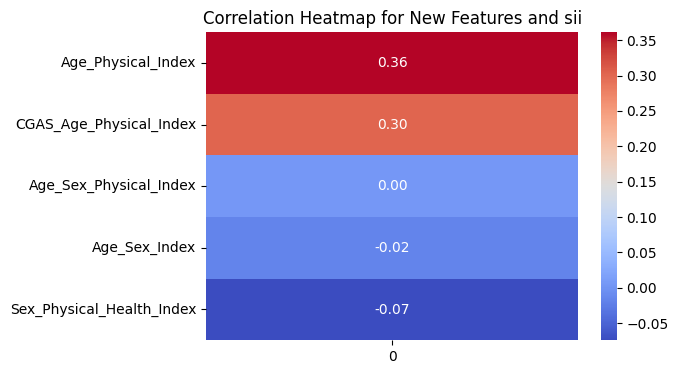

In [ ]:
new_columns = ['CGAS_Age_Physical_Index', 'Age_Sex_Physical_Index', 'Age_Sex_Index',
               'Sex_Physical_Health_Index', 'Age_Physical_Index']

# محاسبه همبستگی بین ویژگی‌های جدید و ستون 'sii'
correlation_with_sii = hbn_data[new_columns].corrwith(hbn_data['sii'])

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_with_sii.sort_values(ascending=False).to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap for New Features and sii")
plt.show()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  حرف ستون ها با corrolation پایین
</p>

In [ ]:
hbn_data = hbn_data.drop(columns=['Sex_Physical_Health_Index', 'Age_Sex_Index','Age_Sex_Physical_Index'])

##▶ Datasets Merging

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   گروه بندی دیتاست Parquet بر اساس ستون id
</p>

In [ ]:
parquet_grouped_data = parquet_data.groupby('id')

<ipython-input-60-3aa3e52e014e>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  parquet_grouped_data = parquet_data.groupby('id')


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   محاسبه میانگین مقادیر ستون‌های عددی برای هر گروه و ترکیب دیتافریم ها
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
** کد reset_index() ایندکس قدیمی را حذف و یک ایندکس جدید ایجاد می‌کند.
</p>

In [ ]:
parquet_grouped_data_df = parquet_grouped_data.mean().reset_index()
merged_data = pd.merge(hbn_data,parquet_grouped_data_df, on='id', how='inner')

In [ ]:
merged_data.head()

,Unnamed: 0,Enrol_Season,Age,Sex,CGAS-Season,CGAS-Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,battery_voltage,weekday,quarter,relative_date_PCIAT,time_of_day_hours,Acceleration_Magnitude,Activity_Level,Mean_Enmo,Variance_Enmo,time_of_day
0,3.0,3.0,9,0,0.0,71.0,2.0,18.292347,56.0,81.6,...,4053.578857,4.470182,3.0,53.201683,13.523217,0.958392,0.001546,0.047388,0.011311,1.140642
1,5.0,1.0,13,1,3.0,50.0,2.0,22.279952,59.5,112.2,...,3963.828125,3.890348,3.0,73.744888,12.049424,0.986623,0.000111,0.016013,0.001601,1.454580
2,20.0,3.0,14,0,1.0,68.0,1.0,17.168636,66.5,108.0,...,3873.381836,3.491333,2.0,25.336914,11.497755,0.978774,0.003363,0.035966,0.012794,1.497052
3,22.0,0.0,12,0,3.0,58.0,0.0,17.819010,60.5,178.0,...,3865.742676,4.026340,4.0,49.543240,11.501537,0.970468,0.001064,0.033645,0.007260,1.514121
4,25.0,1.0,9,0,3.0,60.0,0.0,17.089151,53.2,68.8,...,3974.910889,4.168412,4.0,-1.168288,11.565926,0.968677,0.008501,0.058280,0.038920,1.553984


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   ذخیره کردن دیتاست های ادغام شده به عنوان دیتاست نهایی برای استفاده مجدد
</p>

In [ ]:
merged_data.to_csv('/content/drive/My Drive/bootcamp_project/final1-data.csv', index=False)
print("Dataset has been saved to Google Drive!")

Dataset has been saved to Google Drive!


##▶ Imbalanced Dataset

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   جدا کردن ستون id و sii برای محاسبه توزیع ستون sii ( Target )
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
** جداسازی ستون id از دیتافریم به دلیل انجام عملیات  over-sampling در ادامه است که بر روی داده های object انجام نمی شود
</p>

In [ ]:
y = merged_data['sii']
x = merged_data.drop(columns=['sii'])
id_column = x['id']
x = x.drop(columns=['id'])

sii
0.0    0.585341
1.0    0.267068
2.0    0.137550
3.0    0.010040
Name: proportion, dtype: float64


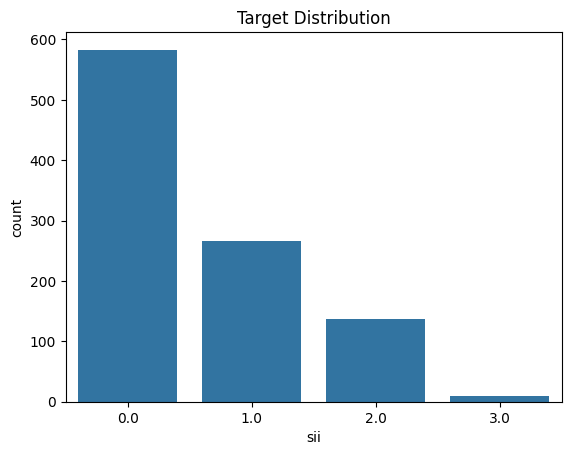

In [ ]:
# بررسی توزیع ستون هدف
print(y.value_counts(normalize=True))
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()

###▶ oversampling

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   در اینجا از SMOTE ه یک تکنیک برای متعادل‌سازی داده‌های نامتوازن در مدل‌های یادگیری ماشین است استفاده می کنیم
البته در این قسمت به طور خاص،از SMOTE برای افزایش تعداد نمونه‌های کلاس کمتر در یک مسئله طبقه‌بندی استفاده می‌کنیم.
</p>

In [ ]:
smote = SMOTE(random_state=42)

x_resampled, y_resampled = smote.fit_resample(x, y)

x_resampled = pd.DataFrame(x_resampled, columns=x.columns) #تبدیل به یک "دیتافریم" تا بتوانیم از ویژگی‌های داده‌های جدید به راحتی استفاده کنیم
y_resampled = pd.Series(y_resampled, name=y.name) # تبدیل به یک " سری " تا برچسب‌های جدید (کلاس‌ها) را به همان فرمت اصلی حفظ کنیم

In [ ]:
print("Original data distribution:")
print(y.value_counts(normalize=True))
print("Resampled data distribution:")
print(y_resampled.value_counts(normalize=True))

Original data distribution:
sii
0.0    0.585341
1.0    0.267068
2.0    0.137550
3.0    0.010040
Name: proportion, dtype: float64
Resampled data distribution:
sii
1.0    0.25
0.0    0.25
2.0    0.25
3.0    0.25
Name: proportion, dtype: float64


In [ ]:
print("Shape of x_resampled:", x_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

Shape of x_resampled: (2332, 60)
Shape of y_resampled: (2332,)


##▶ Feature Selection

Correlation with sii:
PCIAT_Max                                 0.660790
PCIAT_Variance                            0.594871
PCIAT_StdDev                              0.591080
Physical-Height                           0.359564
Age                                       0.348898
PreInt_EduHx-computerinternet_hoursday    0.336408
Age_Physical_Index                        0.331567
PCIAT_HighScores                          0.312157
Physical-Weight                           0.306568
CGAS_Age_Physical_Index                   0.277557
BIA-BIA_LST                               0.244463
Acceleration_Magnitude                    0.239702
Physical-BMI                              0.203107
SDS-SDS_Total_T                           0.180675
Physical-Systolic_BP                      0.177828
FGC-FGC_CU                                0.163016
BIA-BIA_BMI                               0.158986
BIA-BIA_FMI                               0.154966
BIA-BIA_Frame_num                         0.145918
BIA-BIA_F

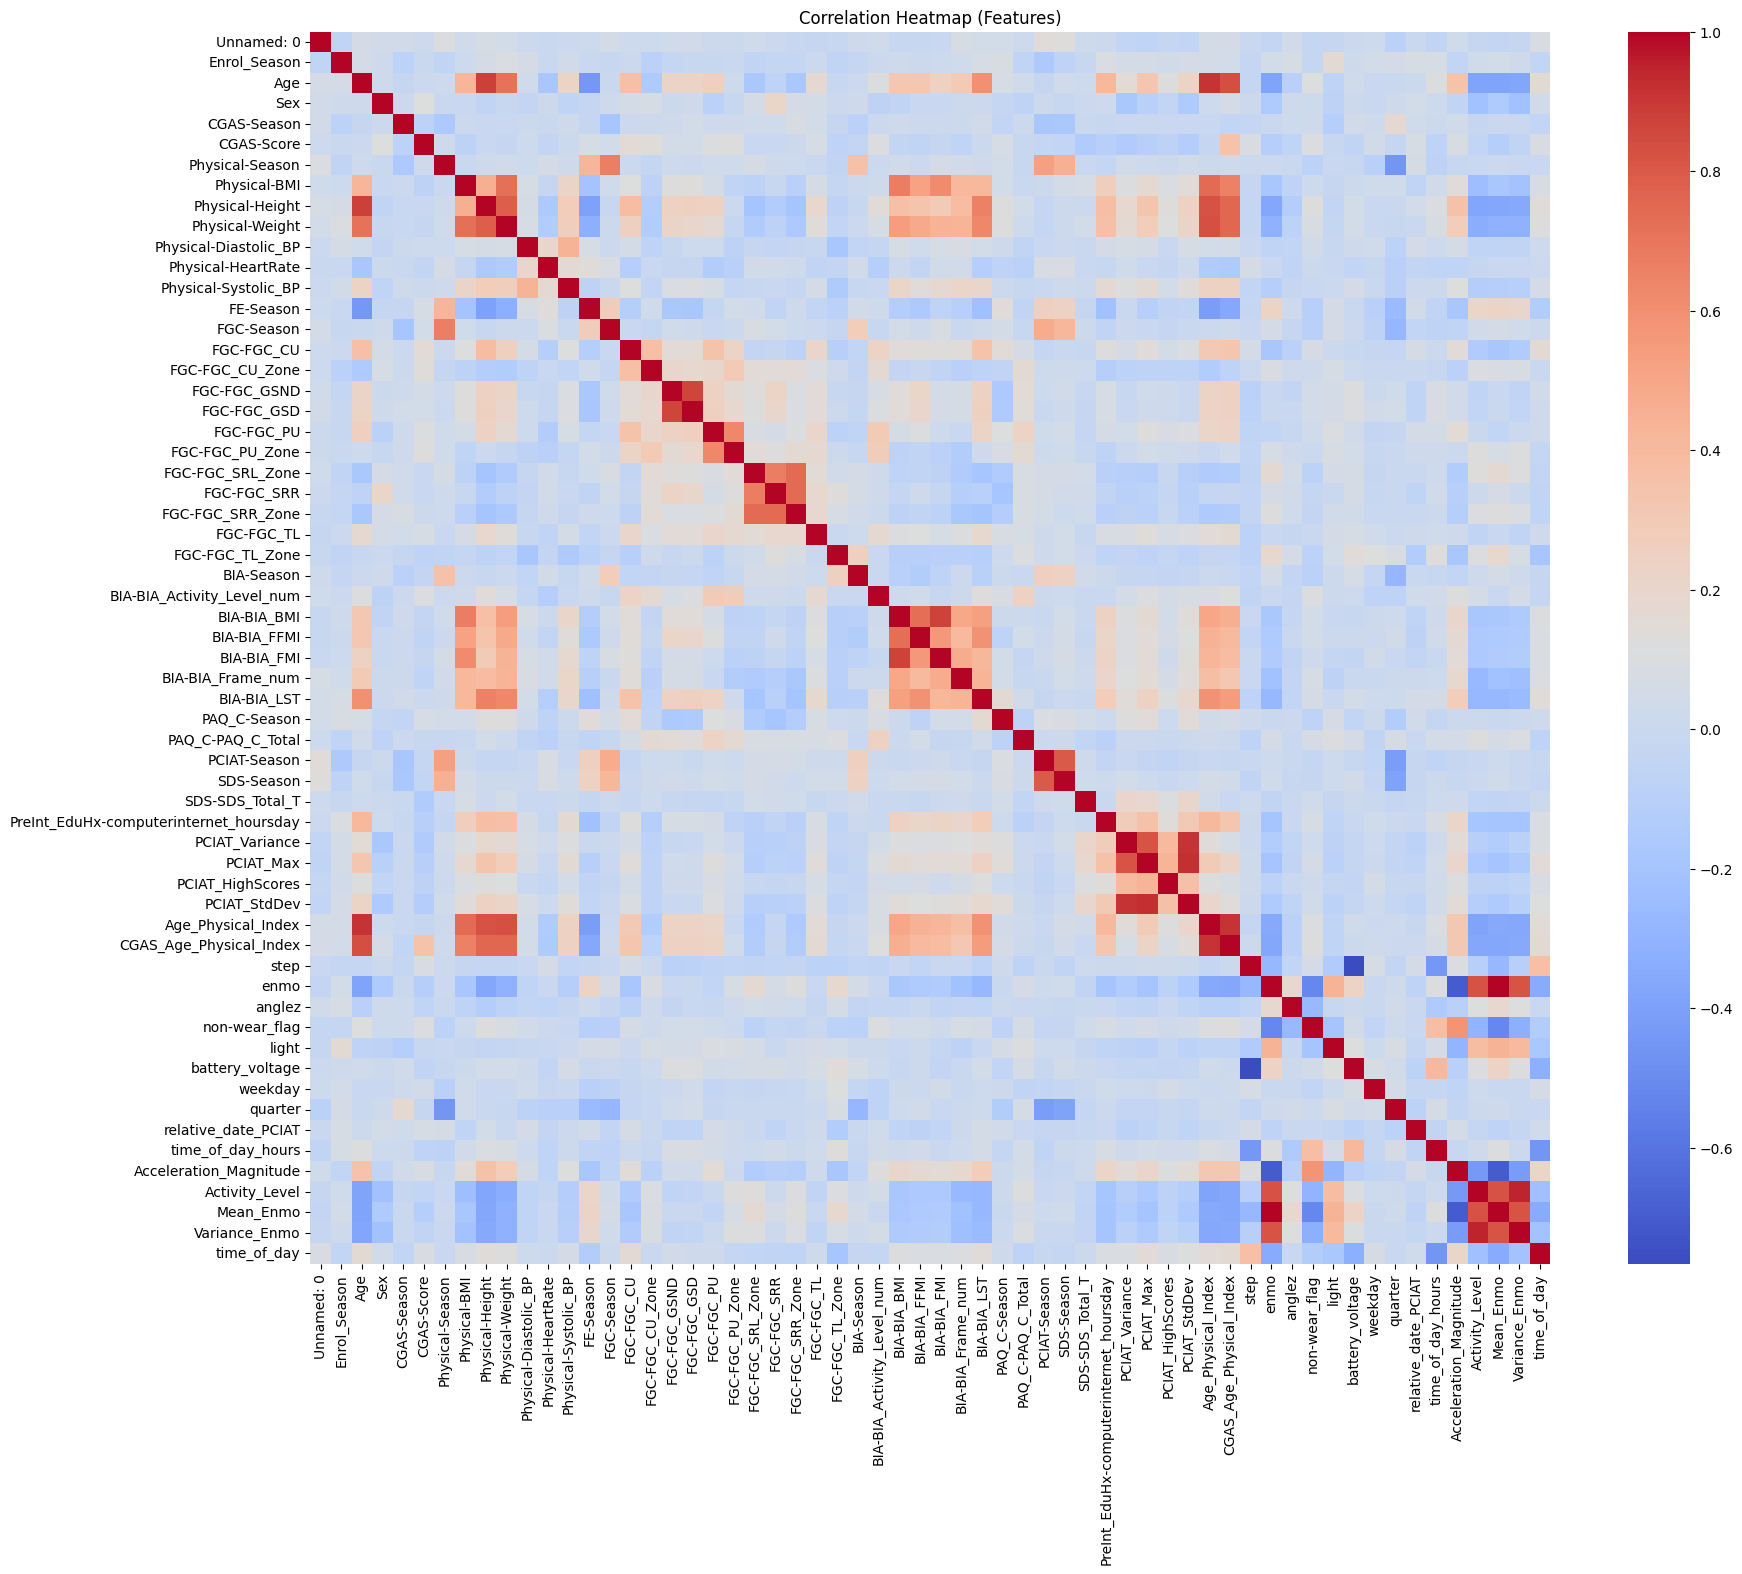

In [ ]:
# محاسبه همبستگی ستون‌های ویژگی با `sii`
correlation_with_target = x.corrwith(y)
print("Correlation with sii:")
print(correlation_with_target.sort_values(ascending=False))

plt.figure(figsize=(20, 16))
sns.heatmap(x.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Features)")
plt.show()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   ویژگی‌های با همبستگی بالا (Highly Correlated Features)
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
اگر دو یا چند ویژگی با همبستگی بسیار بالایی داشته باشند، ممکن است باعث multicollinearity شوند که به مدل آسیب می‌زند. در این صورت،اگر همبستگی بین دو ویژگی بیشتر از ۰.۹ باشد باید یکی از ویژگی‌ها را حذف کنیم.
</p>

In [ ]:
# محاسبه ماتریس همبستگی
correlation_matrix = x.corr()

# شناسایی جفت ویژگی‌هایی با همبستگی بالا
high_corr_pairs = []
threshold = 0.9
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold:
            high_corr_pairs.append((col1, col2))

print("Highly correlated feature pairs:")
print(high_corr_pairs)

Highly correlated feature pairs:
[('Age', 'Age_Physical_Index'), ('PCIAT_Variance', 'PCIAT_StdDev'), ('PCIAT_Max', 'PCIAT_StdDev'), ('PCIAT_StdDev', 'PCIAT_Variance'), ('PCIAT_StdDev', 'PCIAT_Max'), ('Age_Physical_Index', 'Age'), ('Age_Physical_Index', 'CGAS_Age_Physical_Index'), ('CGAS_Age_Physical_Index', 'Age_Physical_Index'), ('enmo', 'Mean_Enmo'), ('Activity_Level', 'Variance_Enmo'), ('Mean_Enmo', 'enmo'), ('Variance_Enmo', 'Activity_Level')]


In [ ]:
# لیست ستون‌هایی که باید حذف شوند
columns_to_drop = []

for col1, col2 in high_corr_pairs:
    if correlation_with_target[col1] > correlation_with_target[col2]:
        columns_to_drop.append(col2)
    else:
        columns_to_drop.append(col1)

print(f"Columns dropped due to high correlation: {columns_to_drop}")

Columns dropped due to high correlation: ['Age_Physical_Index', 'PCIAT_StdDev', 'PCIAT_StdDev', 'PCIAT_StdDev', 'PCIAT_StdDev', 'Age_Physical_Index', 'CGAS_Age_Physical_Index', 'CGAS_Age_Physical_Index', 'enmo', 'Activity_Level', 'Mean_Enmo', 'Activity_Level']


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅   ویژگی‌های با واریانس بسیار کم (Low Variance Features)
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
ویژگی‌هایی که واریانس بسیار کمی دارند (یعنی بیشتر مقادیر آن‌ها ثابت یا مشابه یکدیگر هستند) معمولاً اطلاعات کمی دارند و نمی‌توانند به مدل کمک کنند. می توانیم ویژگی‌هایی با واریانس کمتر از یک مقدار آستانه خاص (مثلاً 0.01 یا 0.05) را حذف کنیم
</p>

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)

# انتخاب ویژگی‌های با واریانس بالا
x_high_variance = selector.fit_transform(x)

# ویژگی‌هایی که واریانس کم دارند
low_variance_features = x.columns[~selector.get_support()]

print("Low Variance Features:")
print(low_variance_features)

Low Variance Features:
Index(['enmo', 'non-wear_flag', 'Acceleration_Magnitude', 'Activity_Level',
       'Mean_Enmo', 'Variance_Enmo'],
      dtype='object')


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  ویژگی‌های تکراری (Redundant Features)
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
ویژگی‌های تکراری معمولاً به عنوان ویژگی‌های مشابه یا یکسان در نظر گرفته می‌شوند. اگر دو ویژگی عملاً یکسان باشند، می‌توان یکی را حذف کرد
</p>

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# محاسبه اطلاعات متقابل بین ویژگی‌ها و هدف
mutual_info = mutual_info_classif(x, y)

# مرتب‌سازی ویژگی‌ها بر اساس اطلاعات متقابل
mutual_info_df = pd.DataFrame(mutual_info, index=x.columns, columns=["Mutual Information"])

# چاپ ویژگی‌هایی که اطلاعات متقابل بالایی دارند (یعنی تکراری هستند)
redundant_features = mutual_info_df[mutual_info_df['Mutual Information'] > 0.1]

print("Redundant Features (High Mutual Information):")
print(redundant_features)

Redundant Features (High Mutual Information):
                Mutual Information
PCIAT_Variance            0.267202
PCIAT_Max                 0.405468
PCIAT_StdDev              0.267618


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  ویژگی‌هایی با کمترین تاثیر بر عملکرد مدل
</p>
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
با استفاده از الگوریتم‌هایی مانند Random Forest، می‌توانیم اهمیت ویژگی‌ها (Feature Importance) را محاسبه کنیم و ویژگی‌هایی که کمترین تاثیر را دارند حذف کنیم.
</p>

                                   Feature  Importance
40                               PCIAT_Max    0.129659
39                          PCIAT_Variance    0.077523
42                            PCIAT_StdDev    0.069026
44                 CGAS_Age_Physical_Index    0.027903
43                      Age_Physical_Index    0.026923
15                              FGC-FGC_CU    0.023442
8                          Physical-Height    0.022481
37                         SDS-SDS_Total_T    0.022408
16                         FGC-FGC_CU_Zone    0.021914
9                          Physical-Weight    0.020524
26                              BIA-Season    0.019422
7                             Physical-BMI    0.019169
2                                      Age    0.018884
38  PreInt_EduHx-computerinternet_hoursday    0.018336
11                      Physical-HeartRate    0.017055
45                                    step    0.015665
41                        PCIAT_HighScores    0.015268
59        

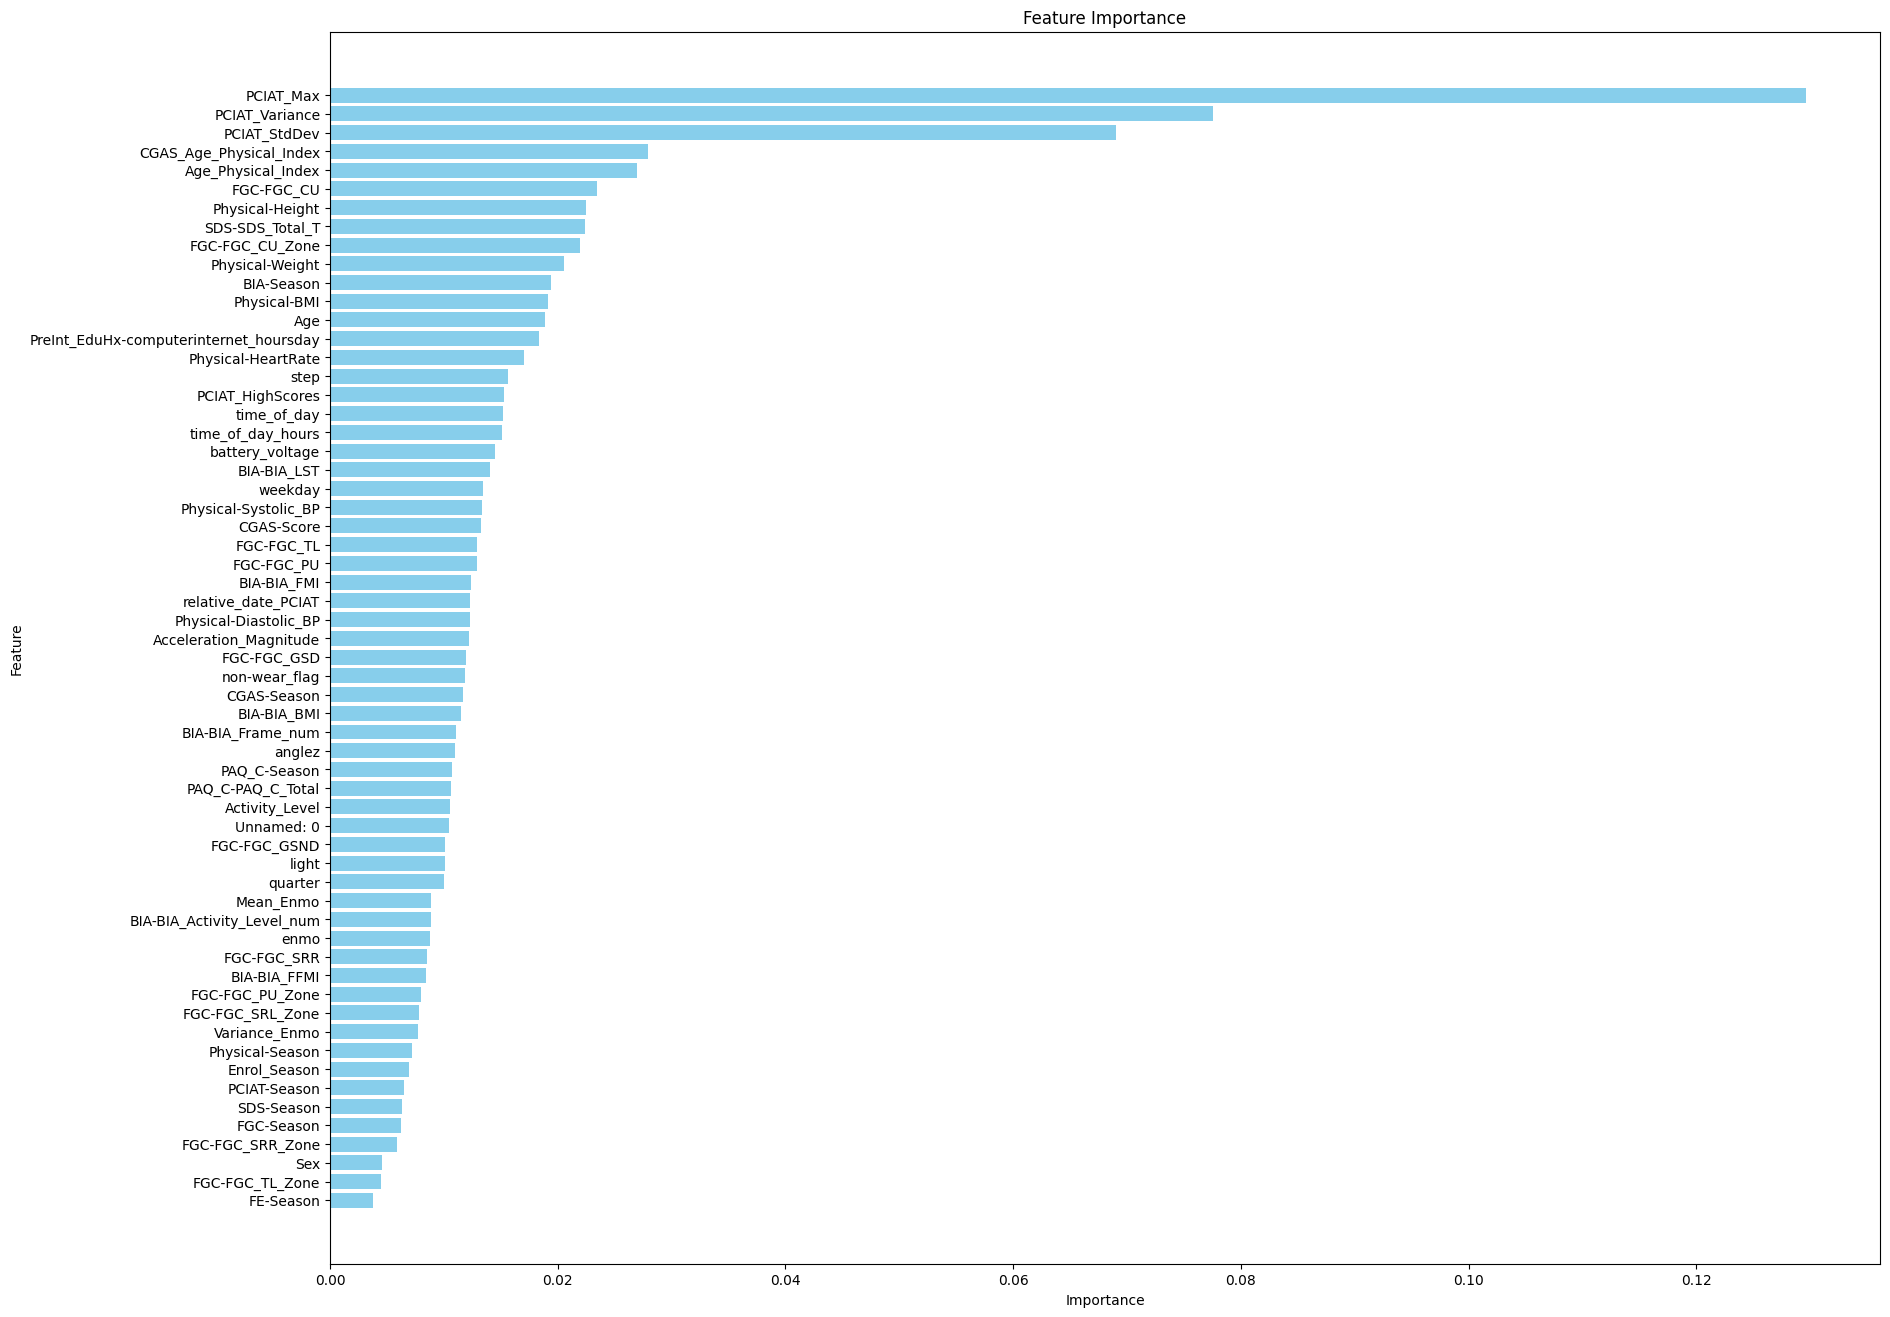

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(x_resampled, y_resampled)

# محاسبه اهمیت ویژگی‌ها
feature_importances = model.feature_importances_

# ایجاد دیتافریم برای نمایش اهمیت ویژگی‌ها
importance_df = pd.DataFrame({
    'Feature': x_resampled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(20, 16))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # معکوس کردن ترتیب برای نمایش صحیح
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
x=x_resampled

In [ ]:
x=x.drop(columns=['FE-Season','FGC-FGC_TL_Zone','FGC-FGC_GSD','Sex',
                  'PCIAT-Season','FGC-Season','SDS-Season','Physical-Season',
                  'FGC-FGC_PU_Zone','Enrol_Season','enmo','Unnamed: 0',
                  'PCIAT_StdDev', 'Mean_Enmo','PCIAT_Variance',
                  'non-wear_flag', 'Acceleration_Magnitude','Variance_Enmo'])

In [ ]:
x['sii'] = y_resampled

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
✅  ذخیره سازی دیتاست نهایی برای ساخت مدل
</p>

In [ ]:
x.to_csv('/content/drive/My Drive/bootcamp_project/dataset_for_model.csv', index=False)
print("Dataset has been saved to Google Drive!")

Dataset has been saved to Google Drive!
